In [17]:
!pip install seaborn
!pip install statsmodels
!pip install scikit-learn

## The Data

Data for both parts comes from Wave 11 of the British Household Panel Survey. This is a multi-year panel of British households, and the data from Wave 11 were collected in the Autumn of 2001. The dataset here is a subset of variables relevant to income and job satisfaction. It is in Parquet format. 

The data conist of households (identified by `hid`) and individuals within that household (identified by `pid`). 

The relevant variables are:

-   `real_hourly_wage`: The inflation-adjusted wage (in 1991 British pounds) of the respondent at his or her main job.
-   `real_hh_non_labour_income` inflation-adjusted income from non-wage sources (such as financial assets).
-   `age`: The respondent's age
-   `job_tenure`: The number of years that the respondent has been working at his or her main job.
-   `higher_degree`, `first_degree`, `hnd_hnc_teaching`, `a_level`, `o_level`, `cse`: These are all dummies for the highest level of education completed, listed here in reverse order of the qualification level.
-   `separate_before_next` is a dummy that is 1 if the employee separated from their employer before the next BHPS wave (one year later), or zero otherwise.
-   `pay_satisfaction` is the employee's self-reported satisfaction with their level of pay (1-7, with 7 being best).
-   `job_security_satisfaction` is the employee's self-reported satisfaction with their job security (1-7, with 7 being best).
-   `work_satisfaction` is the employee's self-reported satisfaction with their daily work (1-7, with 7 being best).
-   There is an index variable that was created by the importation process and is of no consequence

#### Scatterplot matrix of my variables.  Since there are a lot of variables, I have chose to break down my variables down into sub-groups and draw scatterplot matrices of those sub-groups.

In [18]:
import pandas as pd
data = pd.read_parquet('bhps-wave-11.pqt')
data.head()

,hid,pno,real_hourly_wage,real_hh_non_labour_income,age,job_tenure,higher_degree,first_degree,hnd_hnc_teaching,a_level,o_level,cse,separate_before_next,pay_satisfaction,job_security_satisfaction,work_satisfaction
11,10158251,1,4.55978,2178.173584,66.0,0.833333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,6.0,4.0
20,10000054,1,NaN,31451.669922,63.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
29,10000054,2,NaN,31451.669922,66.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
38,10000119,1,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,10246339,1,NaN,12367.541992,41.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN


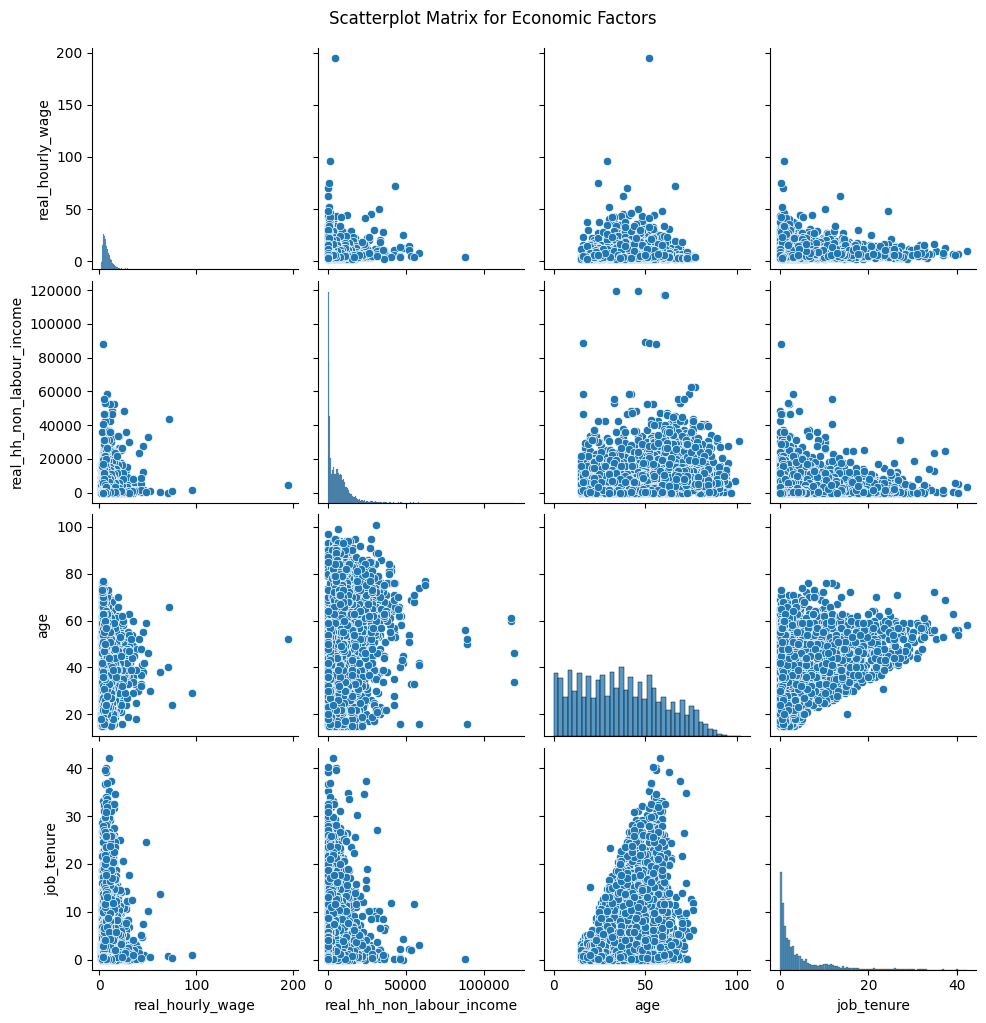

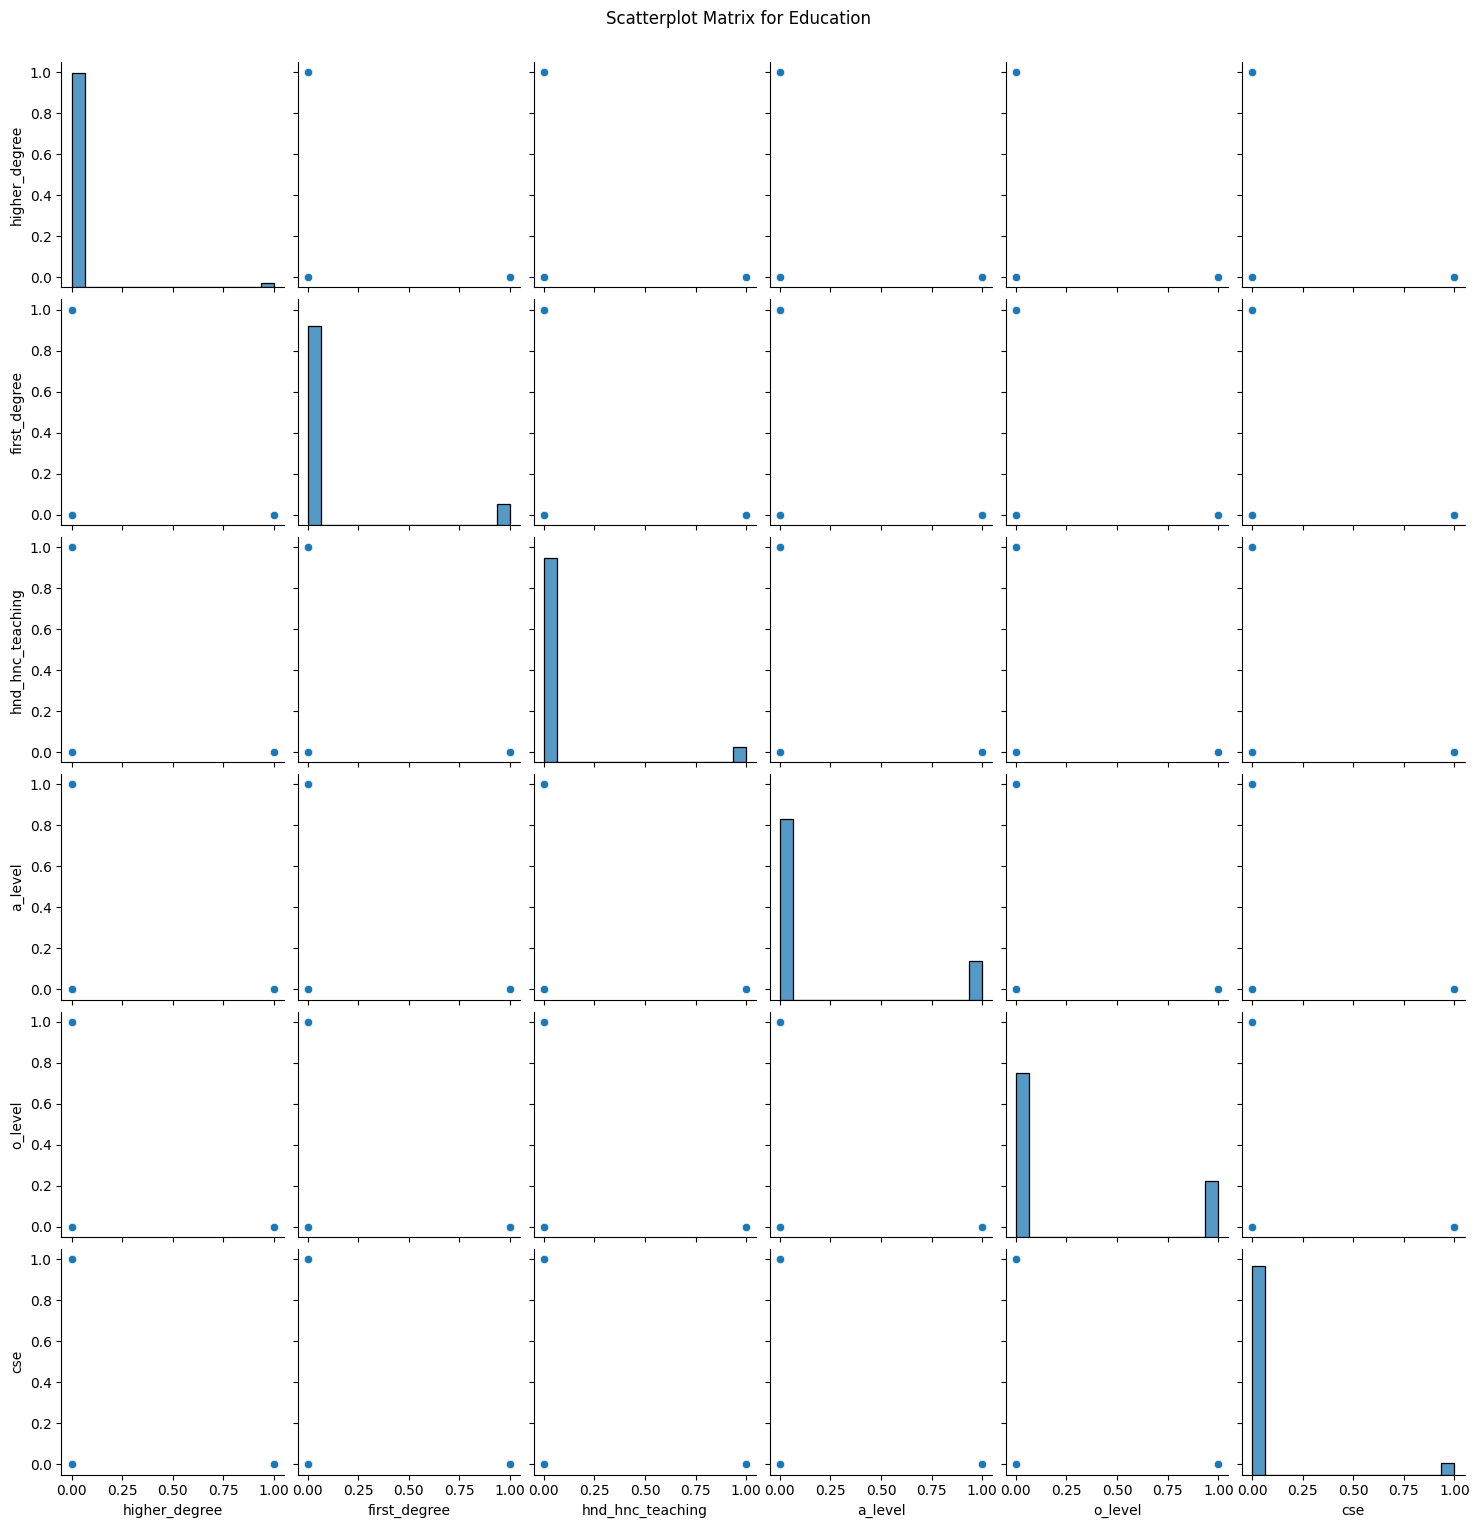

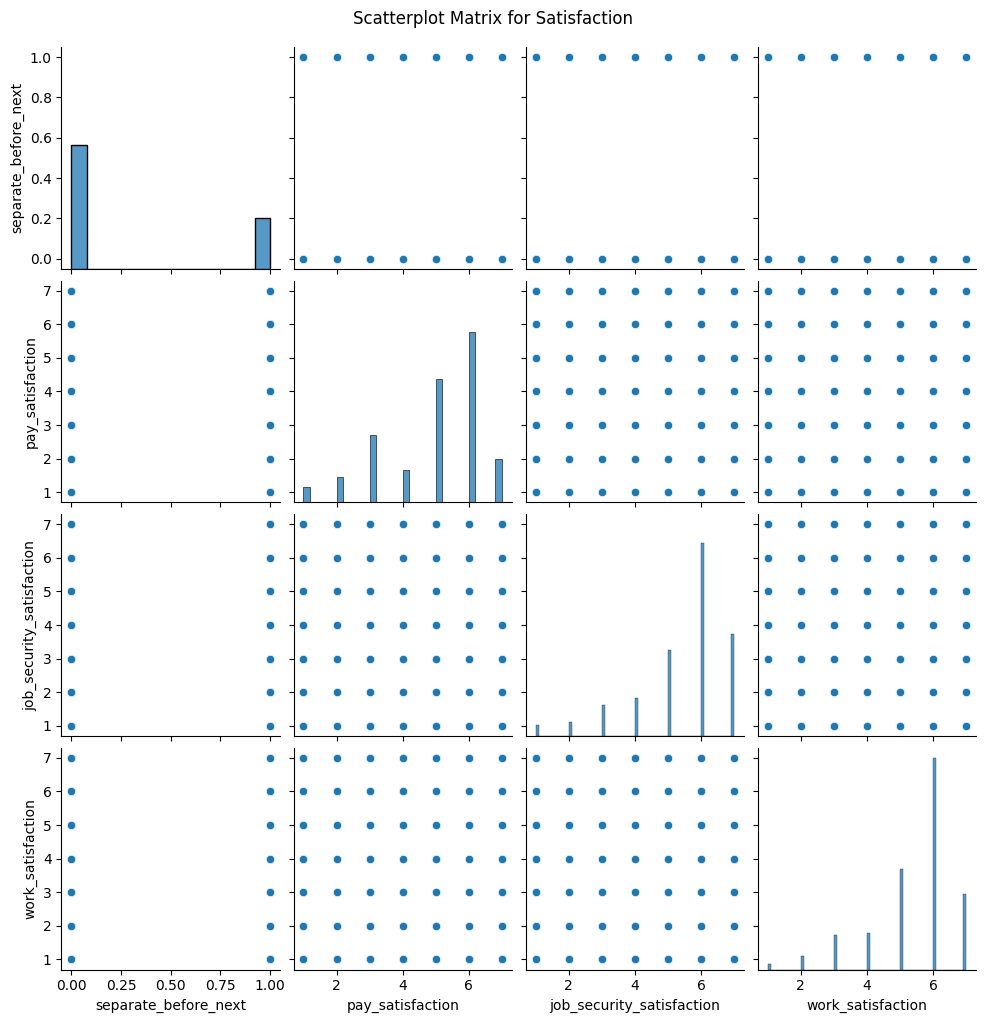

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

economic_factors = data[['real_hourly_wage','real_hh_non_labour_income','age','job_tenure']]
education = data[['higher_degree','first_degree','hnd_hnc_teaching','a_level','o_level','cse']]
satisfaction = data[['separate_before_next','pay_satisfaction','job_security_satisfaction','work_satisfaction']]

sns.pairplot(economic_factors)
plt.suptitle("Scatterplot Matrix for Economic Factors", y=1.02)
plt.show()

sns.pairplot(education)
plt.suptitle("Scatterplot Matrix for Education", y=1.02)
plt.show()

sns.pairplot(satisfaction)
plt.suptitle("Scatterplot Matrix for Satisfaction", y=1.02)
plt.show()

#### Outliers

There are outliers present in the scatterplot matrices. For example, when examining the scatterplots for economic factors, there are clear outliers when comparing real hourly wage to real hh non labour income as well as real hourly wage to age. There are also several outliers when comparing real hh non labour income to age. I will trim the age to a maximum of 65 years to reflect the average age of retirement.

In [20]:
trimmed_data = data[data['age'] <= 65]

#### Linear regression of the wage on education, age, and job tenure. I've also created a polynomial smoother plot to show the relationship between the continuous variables.

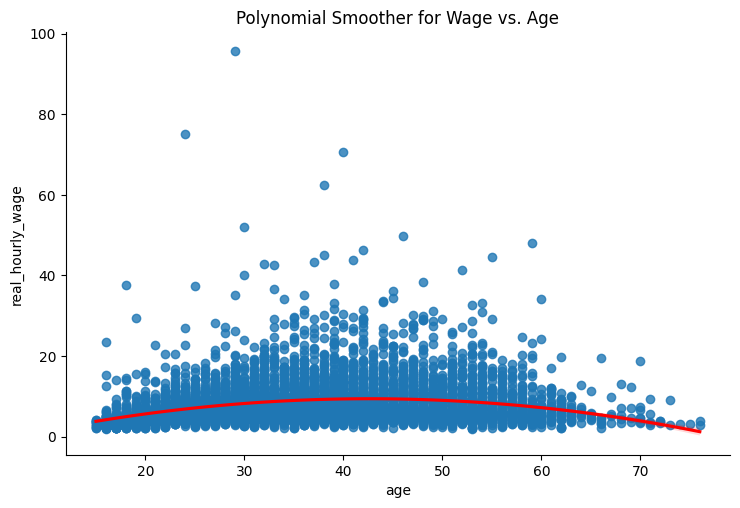

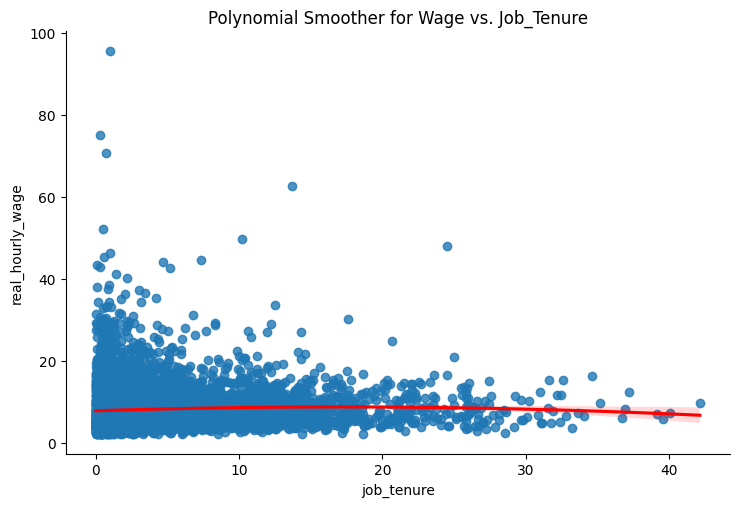

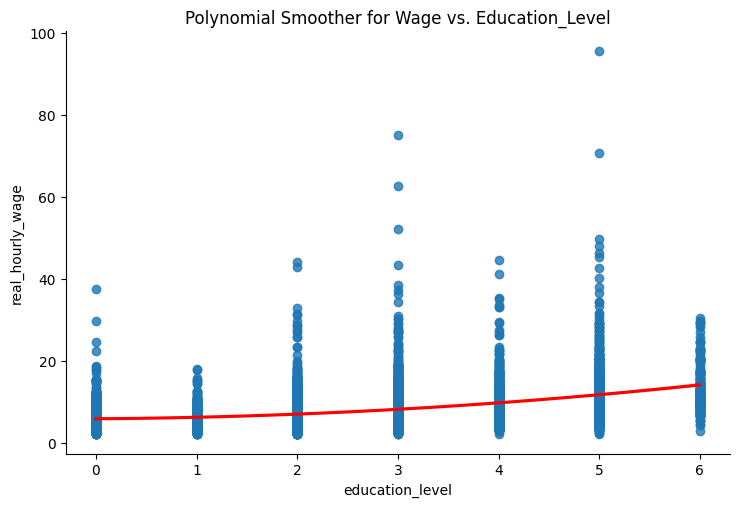

In [21]:
from statsmodels.formula.api import ols
def education_level(row):
    education_mapping = {
        'cse': 1,
        'o_level': 2,
        'a_level': 3,
        'hnd_hnc_teaching': 4,
        'first_degree': 5,
        'higher_degree': 6
    }
    max_level = 0
    for key in education_mapping:
        if pd.notna(row[key]) and row[key] == 1:
            max_level = max(max_level, education_mapping[key])
    return max_level

data['education_level'] = data.apply(education_level, axis=1)
regression_data = data.dropna(subset=['real_hourly_wage', 'age', 'job_tenure', 'education_level'])
model = ols('real_hourly_wage ~ age + job_tenure + education_level', data=regression_data).fit()

for var in ['age', 'job_tenure', 'education_level']:
    sns.lmplot(x=var, y='real_hourly_wage', data=regression_data, order=2, aspect=1.5, line_kws={'color': 'red'})
    plt.title(f'Polynomial Smoother for Wage vs. {var.title()}')
    plt.show()

Ideas if I were to repeat the analysis: For wage vs age I would consider adding a quadratic term for age to capture non-linear effects. I would also add a quadratic term for job tenure and consider a log transformation due to it being positively skewed. I would also consider adding dummy variables for education.

#### Regression with age and job tenure untransformed -  Based on my regression results, here I carry out a test of the hypothesis that a year of age and a year of job tenure have an equal effect on a person's expected wage.

In [22]:
import statsmodels.api as sm

regression_data = trimmed_data.dropna(subset=['real_hourly_wage','age','job_tenure'])
X = regression_data[['age','job_tenure']]
X = sm.add_constant(X)
y = regression_data['real_hourly_wage']
model = sm.OLS(y, X).fit()
print(model.summary())

hypothesis = '(age = job_tenure)'
t_test_result = model.t_test(hypothesis)
print(t_test_result)

                            OLS Regression Results                            
Dep. Variable:       real_hourly_wage   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     89.62
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           3.98e-39
Time:                        08:53:49   Log-Likelihood:                -20051.
No. Observations:                6565   AIC:                         4.011e+04
Df Residuals:                    6562   BIC:                         4.013e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4221      0.209     25.961      0.0

The coefficient for age is significantly different from the coefficient for job tenure: moreover, I can reject the null hypothesis that a year of age and a year of job tenure have an equal effect on a person's expected wage (with a t-stat of 6.071 and a p-value near 0.000), suggesting that each additional year of age is associated with a significantly different change in the real hourly wage compared to each additional year of job tenure.

#### Examining the causes that lead people to quit their jobs - Logistic regression of employer separation on pay, non-labor income, and self-reported job satisfaction, age, tenure, and education

In [23]:
clean_data = trimmed_data.dropna(subset=['real_hourly_wage','real_hh_non_labour_income','pay_satisfaction',
                                 'job_security_satisfaction','work_satisfaction','age',
                                 'job_tenure','higher_degree','first_degree','hnd_hnc_teaching',
                                 'a_level','o_level','cse','separate_before_next'])

X = clean_data[['pay_satisfaction','real_hh_non_labour_income','work_satisfaction','age',
                'job_tenure','higher_degree','first_degree','hnd_hnc_teaching',
                'a_level','o_level','cse']]

X = sm.add_constant(X)
y = clean_data['separate_before_next']
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.561879
         Iterations 6
                            Logit Regression Results                            
Dep. Variable:     separate_before_next   No. Observations:                 2478
Model:                            Logit   Df Residuals:                     2466
Method:                             MLE   Df Model:                           11
Date:                  Sun, 17 Dec 2023   Pseudo R-squ.:                 0.06083
Time:                          08:53:49   Log-Likelihood:                -1392.3
converged:                         True   LL-Null:                       -1482.5
Covariance Type:              nonrobust   LLR p-value:                 8.665e-33
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.7200      0.318      5.411    

#### Using a Bonferroni-Holm correction, I have discovered the number of statistically significant determinants of employer separation in my regression.  I have allowed a five percent chance of incorrectly labeling a variable as statistically significant.

In [24]:
p_values = logit_model.pvalues
ordered_p_values = p_values.sort_values()
m = len(ordered_p_values)
bonferroni_holm_value = [0.05 / (m + 1 - rank) for rank in range(1, m + 1)]

correction_df = pd.DataFrame({
    'Variable': ordered_p_values.index,
    'p-value': ordered_p_values.values,
    'Bonferroni-Holm Value': bonferroni_holm_value
})
significant_variables = correction_df[correction_df['p-value'] < correction_df['Bonferroni-Holm Value']]
number_significant = significant_variables.shape[0]
print(f'Number of statistically significant determinants of employer separation: {number_significant}')
print(significant_variables)

Number of statistically significant determinants of employer separation: 5
            Variable       p-value  Bonferroni-Holm Value
0         job_tenure  4.150908e-11               0.004167
1              const  6.264652e-08               0.004545
2  work_satisfaction  2.774946e-07               0.005000
3                age  2.508078e-06               0.005556
4   pay_satisfaction  5.812601e-05               0.006250


#### Machine learning - I have split my classification sample into a training set and a test set with an 80:20 ratio.


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 1982
Test set size: 496


#### Here I train a gradient-boosted trees model on my training set. I  calculate the optimal number of trees and optimal depth based on the F1 score of the model on my test set.

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
optimal_num_trees = 0
optimal_depth = 0
highest_f1_score = 0
num_trees_options = [50, 100, 150, 200, 250, 300, 350, 400]
depth_options = [1, 2, 3, 4, 5, 6, 7, 8]

for trees in num_trees_options:
    for depth in depth_options:
        model = GradientBoostingClassifier(n_estimators=trees, max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        if f1 > highest_f1_score:
            highest_f1_score = f1
            optimal_num_trees = trees
            optimal_depth = depth

print(f"Optimal number of trees: {optimal_num_trees}")
print(f"Optimal depth: {optimal_depth}")
print(f"Highest F1 score: {highest_f1_score:.4f}")

Optimal number of trees: 350
Optimal depth: 5
Highest F1 score: 0.3478


#### Below I have constructed a neural network consisting of an input layer and a dense layer with a softmax activiation. I have trained this network on my training data to predict a person's separation from their employer.  In the output, I report its performance on the test data.

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn_model = MLPClassifier(hidden_layer_sizes=(), activation='logistic', solver='adam', max_iter = 500, random_state=42)
nn_model.fit(X_train_scaled, y_train)
y_pred_nn = nn_model.predict(X_test_scaled)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Performance Report\nAccuracy: {accuracy_nn:.4f}")

Performance Report
Accuracy: 0.7319
